# Эффективные алгоритмы для SVMs


Нас интересует решение задачи:
$$
\min_{w \in R^n, \zeta \in R^k, b \in R}\frac{1}{2}\|w\|_2^2 + \alpha \sum_{i=1}^k \zeta_i \\
y^{(i)} (w^Tx^{(i)} - b) \geq 1-\zeta_i \quad \forall 1\leq i\leq k\\
\zeta_i \geq 0 \quad \forall 1 \leq i \leq k
$$

In [1]:
import numpy as np
tar = np.zeros((683,))
X = np.zeros((683, 10))

In [7]:
from sklearn.metrics import accuracy_score

In [10]:
def sign(x):
    for i in range(len(x)):
        if x[i] >= 0:
            x[i] = 1
        else:
            x[i] = -1
    return x

In [2]:
with open('task1.txt') as f: #прочитали данные, в y лежат метки классов, в data -- признаки.
    for idx, line in enumerate(f):
        line = line.split(" ")
        for elem in line:
            if elem == '4':
                tar[idx] = 1
            elif elem == '2':
                tar[idx] = -1
            elif elem == '\n':
                continue
            else:
                elem = elem.split(':')
                X[idx][int(elem[0]) - 1] = float(elem[1])

In [3]:
from sklearn.svm import SVC

In [4]:
model_svm = SVC(kernel='linear', C = 1)
model_svm.fit(X, tar)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [5]:
w_svm = model_svm.coef_

In [11]:
accuracy_score(tar, sign(X@w_svm.T))

0.862371888726208

__Проксимальный спуск.__

Выпишем эквивалентную задачу, пусть $w = (w_1, w_0)$.

$$
\min_{w} \dfrac{1}{2}\|w_1\|^2 + \alpha\sum_{i = 1}^{l}(1 - y_i(\langle w_1, x_i\rangle - w_0))_{+} = f(w) + g(w) = f(w) + g(Aw),
$$
где

$$
A = \begin{Vmatrix}
y_1x_1^T & -y_1\\
y_2x_2^T & -y_2\\
\vdots & \vdots\\
y_lx_l^T & -y_l
\end{Vmatrix}
$$
Тогда решим следующие задачи:

$$
\begin{aligned}
&w^{k+1} = \textbf{prox}_{\mu_1f}(w^k - (\mu_1/\mu_2)A^T(Aw^k - z^k + u^k))
\\
&z^{k+1} = \textbf{prox}_{\mu_2g}(Aw^{k+1} + u^k)
\\
&u^{k+1} = u^k + Ax^{k+1} - z^{k+1}
\end{aligned}
$$

Найдем проксимальные отображения для каждой функции.
$$
\textbf{prox}_{\mu f}(w) = \text{arg}\min_{y} \dfrac{1}{2}\|y_1\|_2^2 + \dfrac{\mu}{2}\|y - w\|_2^2,
$$

тогда
$$
\textbf{prox}_{\mu f}(w) = \begin{Vmatrix}
\dfrac{\mu}{1 + \mu}w_1
\\
w_0
\end{Vmatrix}.
$$

$$
\textbf{prox}_{\mu g}(z) = \arg\min_{x} \sum_{i = 1}^l (1 - x_i)_+ + \dfrac{\mu}{2}\|x - z\|_2^2 
$$

Видим, что задача сепарабельна, поэтому

$$
\textbf{prox}_{\mu g}(z)_i = \left\{\begin{aligned}
&z_i,~z_i > 1
\\
&\dfrac{1}{\mu} + z_i, ~z_i < 1 - \dfrac{1}{\mu}
\\
&1,~otherwise
\end{aligned}\right.
$$

In [13]:
import time

In [14]:
l_1 = 683
n_1 = 10

In [25]:
def prox_svm_z(z):
    x = np.zeros(683)
    for i in range(683):
        if z[i] > 1:
            x[i] = z[i]
        elif z[i] < 1 - 1/mu1:
            x[i] = 1/mu1 + z[i]
        else:
            x[i] = 1
    return x

def prox_svm_w(w):
    x = np.zeros(11)
    for i in range(10):
        x[i] = mu2*w[i]/(1 + mu2)
    x[10] = w[10]
    return x

def step_svm_u(u, x, z):
    return u + A@x - z

In [26]:
A = np.zeros((683, 11))
for i in range(683):
    A[i] = np.append(X[i], -1)
    A[i] = tar[i]*A[i]

In [31]:
X1 = np.zeros((683, 11))
for i in range(683):
    X1[i] = np.append(X[i], -1)

In [167]:
eps = 0.1
mu1 = 10000
mu2 = 100 # <= mu1/norm(A)**2
a = 100
mu1 *= a

In [157]:
def svm(w):
    sum1 = 0
    for i in range(683):
        if 1 - A[i]@w >= 0:
            sum1+=(1 - A[i]@w)
    return Norm(w[:-1]) + sum1

In [158]:
def svm2(z):
    sum1 = 0
    for i in range(683):
        if 1 - z[i] >= 0:
            sum1+=(1 - z[i])
    return sum1

In [168]:
u_svm_ad = np.array([0 for _ in range(683)])
w_svm_ad = np.array([1 for _ in range(10)])
w_svm_ad = np.append(w_svm_ad, 0)
z_svm_ad = np.array([1 for _ in range(683)])
nev = 10
obj = 10

In [169]:
start = time.time()
svm_ad_obj = []
svm_ad_acc = []
while obj > eps:
    w = prox_svm_w(w_svm_ad - mu2/mu1*A.T@(A@w_svm_ad - z_svm_ad + u_svm_ad))
    z = prox_svm_z(A@w + u_svm_ad)
    u = step_svm_u(u_svm_ad, w, z)
    nev = L2(w, w_svm_ad)
    obj = abs(svm(w) - svm(w_svm_ad))
    acc = accuracy_score(tar, sign(X1@w_svm_ad))
    #print(obj, svm(w_svm_ad))
    svm_ad_obj.append(obj)
    svm_ad_acc.append(acc)
    w_svm_ad = w
    z_svm_ad = z
    u_svm_ad = u
end = time.time()

In [170]:
mu1/np.linalg.norm(A)**2

185.0680018792436

Качество

In [171]:
accuracy_score(tar, sign(X1@w_svm_ad))

0.9033674963396779

Время выполнения

In [172]:
print(end - start)

0.5939924716949463


Количество итераций

In [173]:
len(svm_ad_obj)

125

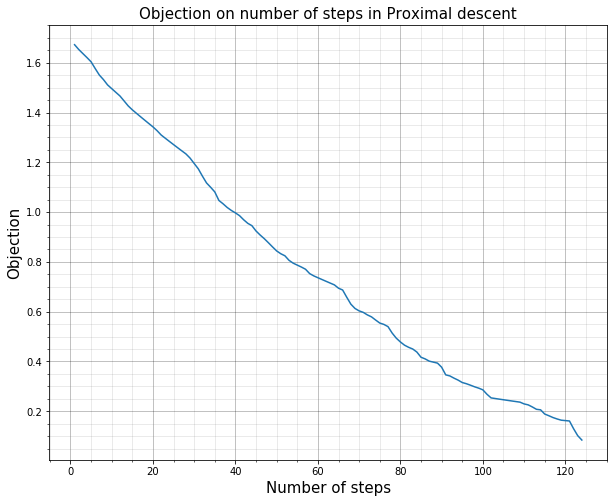

In [174]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 8])
plt.plot(range(1, len(svm_ad_obj)), svm_ad_obj[1:])
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Objection', fontsize=15)
plt.title('Objection on number of steps in Proximal descent', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()


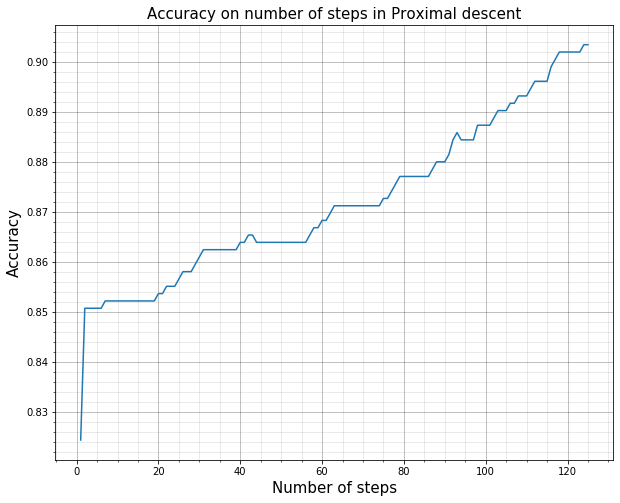

In [175]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(svm_ad_acc)), svm_ad_acc)
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy on number of steps in Proximal descent', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

__ADMM.__

Рассмотрим эквивалентную задачу.

Тогда
$$
\begin{aligned}
&\min_{w, z}\dfrac{1}{2}\|w\|_2^2 + C\sum_{i = 1}^{l}(1 - z_i)_+
\\
&s.t ~Aw = z,
\end{aligned}
$$

$A$ - матрица, аналогичная матрице из проксимального спуска.

Запишем модифицированный Лагранжиан

$$
L_{r}(w, z, y) = \dfrac{1}{2}\|w\|_2^2 + C\sum_{i = 1}^{l}(1 - z_i)_+ + u^T(Aw - z) +  \dfrac{r}{2}\|Aw - z\|^2_2
$$

Тогда получим следующие шаги метода

$$
\begin{aligned}
&w^{k+1} = \text{arg}\min_{w}L_r(w, z^k, u^k)
\\
&z^{k+1} = \text{arg}\min_{z}L_r(w^{k+1}, z, u^k)
\\
&u^{k+1} = u^{k} + r(Aw^{k+1} - z^{k+1})
\end{aligned}
$$

Решим первую задачу:

$$
w^{k+1} = (I + rA^TA)^{-1}A^T(rz^k - u^k).
$$

Вторую:
$$
z^{k+1}_i = \left\{\begin{aligned}
&\dfrac{r[Aw^{k+1}]_i + u^{k}_i + C}{r}, ~r[Aw^{k+1}]_i + u^{k}_i < r - C
\\
&\dfrac{r[Aw^{k+1}]_i + u^{k}_i}{r}, ~r[Aw^{k+1}]_i + u^{k}_i > r
\\
&1, ~otherwise
\end{aligned}\right.
$$

In [142]:
def lagr_svm_w(B, z, u):
    return B@(r*z - u)

def lagr_svm_z(m, u):
    z = np.zeros(l_1)
    for i in range(l_1):
        if r*m[i] + u[i] < r - C:
            z[i] = (r*m[i] + u[i] + C)/r
        elif r*m[i] + u[i] > r:
            z[i] = (r*m[i] + u[i])/r
        else:
            z[i] = 1
    return z

def svm3(w):
    sum1 = 0
    for i in range(683):
        if 1 - A1[i]@w >= 0:
            sum1+=(1 - A1[i]@w)
    return Norm(w[:-1]) + sum1

In [143]:
eps = 0.01
obj = 10
r = 10
C = 10
A1 = A[:, :-1]
B = np.linalg.inv((np.eye(n_1) + r*A1.T@A1))@A1.T
w_svm_ad = np.array([1 for _ in range(n_1)])
z_svm_ad = np.zeros(l_1)
u_svm_ad = np.zeros(l_1)

In [144]:
start = time.time()
svm_ad_obj = []
svm_ad_acc = []
while obj > eps:
    w = lagr_svm_w(B, z_svm_ad, u_svm_ad)
    z = lagr_svm_z(A1@w, u_svm_ad)
    u = u_svm_ad + r*(A1@w - z)
    obj = abs(svm3(w) - svm3(w_svm_ad))
    acc = accuracy_score(tar, sign(X@w_svm_ad))
    svm_ad_obj.append(obj)
    svm_ad_acc.append(acc)
    w_svm_ad = w
    z_svm_ad = z
    u_svm_ad = u
end = time.time()

Время выполнения

In [145]:
end - start

0.29680347442626953

Количество итераций

In [146]:
len(svm_ad_obj)

52

Качество

In [147]:
acc

0.9736456808199122

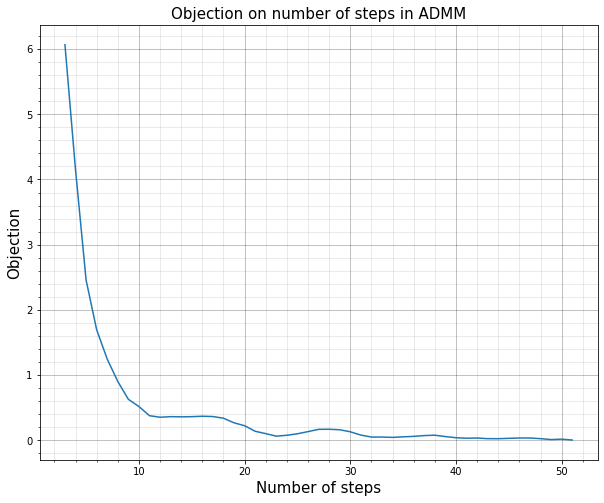

In [151]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 8])
plt.plot(range(3, len(svm_ad_obj)), svm_ad_obj[3:])
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Objection', fontsize=15)
plt.title('Objection on number of steps in ADMM', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

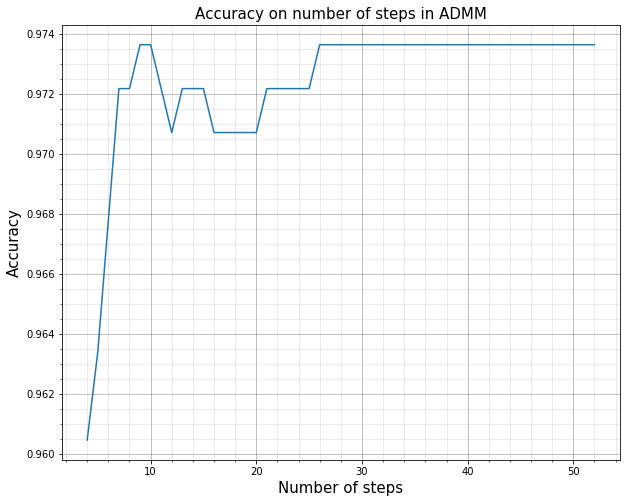

In [154]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 8])
plt.plot(range(4, 1+len(svm_ad_acc)), svm_ad_acc[3:])
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy on number of steps in ADMM', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

__Метод проекции градиента.__

Для этого метода будем оптимизировать двойственную задачу. Построение двойственной задачи сделано в лекции Воронцова.

$$
\begin{aligned}
&\min_{\alpha} \dfrac{1}{2}\alpha^TK\alpha - \mathbf{1}^T\alpha
\\
&y^T\alpha = 0, ~0 \leqslant \alpha_i \leqslant C,
\end{aligned}
$$

$C$ -- это константа перед суммой, $K_{ij} = y_iy_jx_i^Tx_j$

Шаг будет следующим

$$
\alpha^{k+1} = \Pi_{Q}(\alpha^k - s^k\nabla(\dfrac{1}{2}\alpha^TK\alpha - \mathbf{1}^T\alpha)).
$$

$$
\nabla(\dfrac{1}{2}\alpha^TK\alpha - \mathbf{1}^T\alpha) = K\alpha - \mathbf{1},
$$

$$
s^k = \dfrac{r_k^Tr_k}{r_k^Tg_k}, ~r_k = \alpha^k - \alpha^{k - 1}, ~g_{k} = \nabla f(\alpha^k) - \nabla f(\alpha^{k-1})
$$

In [2010]:
K = np.zeros((l_1, l_1))
for i in range(l_1):
    for j in range(l_1):
        K[i, j] = tar[i]*tar[j]*X[i]@X[j]

In [2011]:
def grad_svm_proj(a):
    return K@a - np.array([1 for _ in range(l_1)])

def step_svm_proj():
    pass

def proj_svm(a):
    a = a - a@tar/(np.linalg.norm(a)*np.linalg.norm(tar))*a
    for i in range(l_1):
        if a[i] > C:
            a[i] = C
        elif a[i] < 0:
            a[i] = 0
    return a

In [2058]:
C = 10
eps = 0.1
a_0 = np.array([1 for _ in range(l_1)])
s_0 = 0.0001
g_0 = grad_svm_proj(a_0)
obj = 10

In [2059]:
def dual_svm(a):
    return 1/2*a.reshape(1, l_1)@(K@a) - np.array([1 for _ in range(l_1)])@a

In [2060]:
start = time.time()
svm_pg_obj = []
svm_pg_acc = []
while obj > eps:
    a = proj_svm(a_0 - s_0*g_0)
    r = a - a_0
    g = grad_svm_proj(a)
    obj = abs(dual_svm(a)[0] - dual_svm(a_0)[0])
    svm_pg_obj.append(obj)
    w = np.zeros(10)
    for i in range(l_1):
        w+=a[i]*tar[i]*X[i]
    acc = accuracy_score(tar, sign(X@w))
    svm_pg_acc.append(acc)
    #s_0 = r@r/r@g
    a_0 = a
    g_0 = g
end = time.time()

Время выполнения 

In [2061]:
end - start

0.08477091789245605

Качество

In [2062]:
accuracy_score(tar, sign(X@w))

0.9604685212298683

Количество итераций

In [2063]:
len(svm_pg_acc)

15

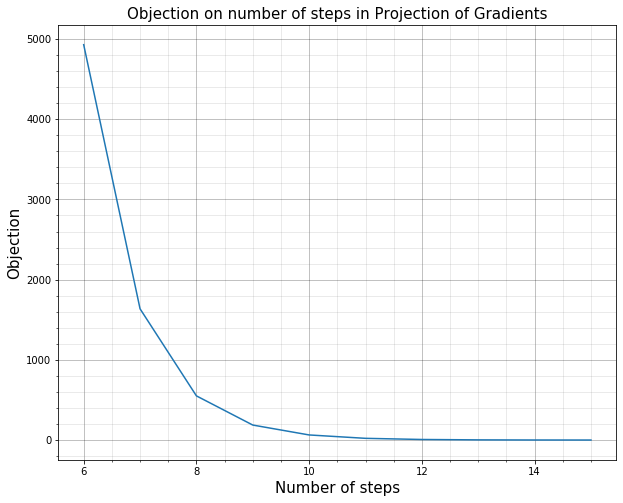

In [2200]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 8])
plt.plot(range(6, len(svm_pg_obj)+1), svm_pg_obj[5:])
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Objection', fontsize=15)
plt.title('Objection on number of steps in Projection of Gradients', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

__Сглаживание.__

$$
\begin{aligned}
&min_{w} \dfrac{1}{2}\|w_1\|_2^2 + \max_{0\leqslant u_i \leqslant 1} \left[ \sum_{i = 1}^l \alpha u_i(1 - y_i(w_1^Tx_i - w_0)) - \dfrac{\mu}{2}u_i^2 \right]
\end{aligned}
$$


Решим задачу максимизации

$$u_i = \left\{
\begin{aligned}
&1, \alpha(1 - y_i(w_1^Tx_i - w_0)) > \mu
\\
&0, \alpha(1 - y_i(w_1^Tx_i - w_0)) < 0
\\
&\dfrac{\alpha(1 - y_i(w_1^Tx_i - w_0))}{\mu}, otherwise
\end{aligned}
\right.
$$

$$
f_{\mu}(w) = \dfrac{1}{2}\|w\|_2^2 + \sum_{i = 1}^l \alpha u_i(1 - y_i(w^Tx_i - w_0)) - \dfrac{\mu}{2}u_i^2
$$


$$z_k = argmin_{z}\left[\nabla^T f_{\mu}(w_k)(z-w_k)+\frac{L}{2}\|z-w_k\|_2^2\right].$$

Приравняем градиент нулю, найдем $z$:

$$\nabla f(w_k) + L(z-w_k) = 0$$

$$z_k = -\frac{1}{L}\nabla f_{\mu}(w_k) + w_k$$

$$r_k = argmin_r\left[\frac{L}{\sigma_2}d_2(r) +  \sum\limits_{i=0}^k\alpha_i\left(f_{\mu}(w_i) + \nabla^Tf_{\mu}(w_i)(r-w_i)\right)\right].$$


$$r_k = argmin_r \left[\frac{L}{2}\|r\|_2^2 + \sum\limits_{i=0}^k\frac{i+1}{2}(f_{\mu}(w_i) + \nabla^Tf_{\mu}(w_i)(r-w_i))\right].$$

Приравняем градиент нулю, найдем $r$:

$$Lr + \sum\limits_{i=0}^k \frac{i+1}{2}\nabla f(w_i) = 0 \Rightarrow r_k = - \frac{1}{L}\sum\limits_{i=0}^k \frac{i+1}{2}\nabla f_{\mu}(w_i).$$

$$w_{k+1} = \frac{2}{k+3} r_k + \frac{k+1}{k+3}z_k.$$

In [2131]:
def smooth_svm_u(w):
    u = np.zeros(l_1)
    for i in range(l_1):
        if C*(1 - tar[i]*(w[:-1]@X[i] - w[-1])) > mu:
            u[i] = 1
        elif C*(1 - tar[i]*(w[:-1]@X[i] - w[-1])) < 0:
            u[i] = 0
        else:
            u[i] = C*(1 - tar[i]*(w[:-1]@X[i] - w[-1]))/mu
    return u

        
def gradient_svm_sm_mu(w, u):
    s = np.zeros(10)
    s_0 = 0
    tmp = w
    for i in range(l_1):
        s += u[i]*tar[i]*X[i]
        s_0 -= u[i]*tar[i]
    s = np.hstack((s, s_0))
    tmp[-1] = 0
    return tmp - s


def svm_sm_z(w, g):
    return -1/L*g + w


In [2190]:
eps = 0.01 
obj = 10 
w_svm_sm = np.array([0 for _ in range(10)])
w_svm_sm = np.append(w_svm_sm, 0)
L = 1000
C = 1
mu = 10
r = np.zeros(n_1+1)

In [2191]:
accuracy_score(tar, sign(X1@w_svm_sm))

0.34992679355783307

In [2192]:
start = time.time()
svm_sm_obj = []
svm_sm_acc = []
i = 0
while obj > eps:
    u = smooth_svm_u(w_svm_sm)
    g = gradient_svm_sm_mu(w_svm_sm, u)
    z = svm_sm_z(w_svm_sm, g)
    r = -float((i+1))*g/(2*L) + r
    w = 2/(i + 3)*r + (i + 1)/(i + 3)*z 
    obj = (abs(svm(w) - svm(w_svm_sm)))
    acc = accuracy_score(tar, sign(X1@w_svm_sm))
    svm_sm_obj.append(obj)
    svm_sm_acc.append(acc)
    w_svm_sm = w
    i += 1
end = time.time()

Количество итераций

In [2193]:
i

37

Время выполнения

In [2194]:
abs(start - end)

0.8762781620025635

Качество

In [2195]:
accuracy_score(tar, sign(X1@w_svm_sm))

0.9663250366032211

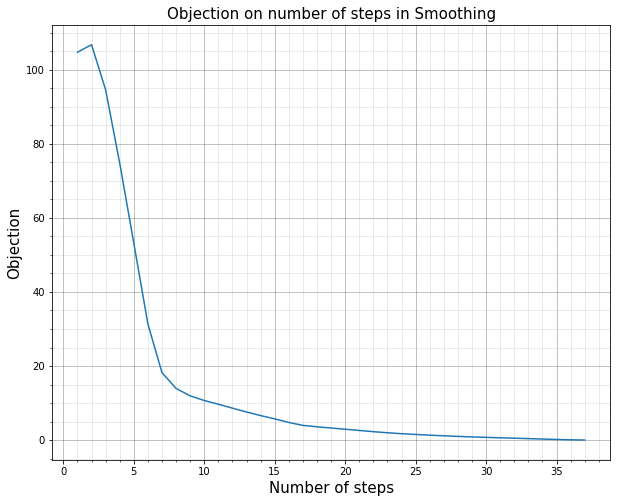

In [2196]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 8])
plt.plot(range(1, len(svm_sm_obj)+1), svm_sm_obj)
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Objection', fontsize=15)
plt.title('Objection on number of steps in Smoothing', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

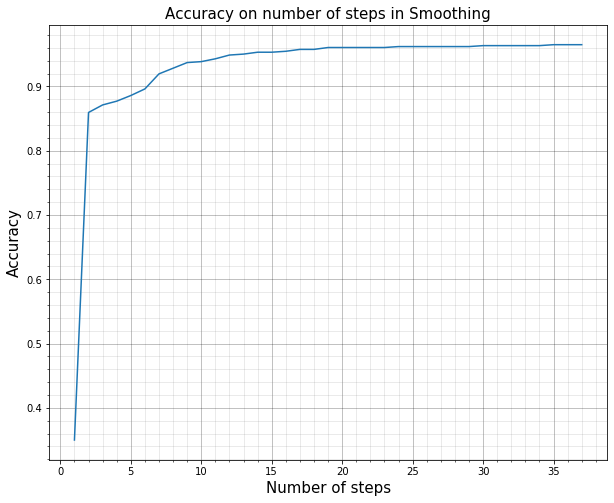

In [2197]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 8])
plt.plot(range(1, len(svm_sm_acc)+1), svm_sm_acc)
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy on number of steps in Smoothing', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

__Субградиентный спуск.__

Найдем субградиент целевой функции

$$
[\nabla f(w) + g(w)]_{w_0} = w_0 - \alpha\sum_{i = 1}^l\left\{\begin{aligned}
&y_i, ~ 1 - y_iw_1^Tx_i + y_iw_0 > 0
\\
&[0; y_i], ~1 - y_iw_1^Tx_i + y_iw_0 = 0
\\
&0, ~1 - y_iw_1^Tx_i + y_iw_0 < 0
\end{aligned}\right.
$$

$$
[\nabla f(w) + g(w)]_{k < n} = w_{1_k} - \alpha\sum_{i = 1}^l\left\{\begin{aligned}
&-y_ix_i^k, ~ 1 - y_iw_1^Tx_i + y_iw_0 > 0
\\
&[-y_ix_i^k; 0], ~1 - y_iw_1^Tx_i + y_iw_0 = 0
\\
&0, ~1 - y_iw_1^Tx_i + y_iw_0 < 0
\end{aligned}\right.
$$

Тогда шаг 

$$
w^{k+1} = w^{k} - s^k\dfrac{\nabla f(w_k) + g(w_k)}{\|\nabla f(w_k) + g(w_k)\|_2}
$$

In [1987]:
def subgrad_svm(w):
    g = np.zeros(11)
    for j in range(11):
        if j <= 9:
            g[j] = w[j]
            for i in range(l_1):
                if 1 - tar[i]*X[i]@w[:-1] + tar[i]*w[-1] > 0:
                    g[j] -= C*tar[i]*X[i][j]
                elif 1 - tar[i]*X[i]@w[:-1] + tar[i]*w[-1] == 0:
                    g[j] -= C*np.random.uniform(0, tar[i]*X[i][j], 1)[0]
                else:
                    continue
        else:
            g[j] = w[j]
            for i in range(l_1):
                if 1 - tar[i]*X[i]@w[:-1] + tar[i]*w[-1] > 0:
                    g[j] += C*tar[i]
                elif 1 - tar[i]*X[i]@w[:-1] + tar[i]*w[-1] == 0:
                    g[j] -= C*np.random.uniform(0, tar[i], 1)[0]
                else:
                    continue
    return g      

In [2090]:
eps = 0.01
w_svm_sg = np.array([1 for _ in range(10)])
w_svm_sg = np.append(w_svm_sg, 0)
obj = 10
sg1 = subgrad_svm(w_svm_sg)
norm1 = Norm(sg1)
s = 0.1

In [2091]:
start = time.time()
svm_sb_obj = []
svm_sb_acc = []
while obj > eps:
    sg = subgrad_svm(w_svm_sg)
    norm = Norm(sg)
    w = w_svm_sg - s*sg/norm
    s = 0.1*norm/norm1
    obj = abs(svm(w) - svm(w_svm_sg))
    svm_sb_obj.append(obj)
    acc = accuracy_score(tar, sign(X1@w_svm_sg))
    svm_sb_acc.append(acc)
    w_svm_sg = w
end = time.time()

Время выполнения

In [2092]:
end - start

16.015039682388306

Количество итераций

In [2093]:
len(svm_sb_obj)

147

Качество

In [2094]:
accuracy_score(tar, sign(X1@w))

0.9736456808199122

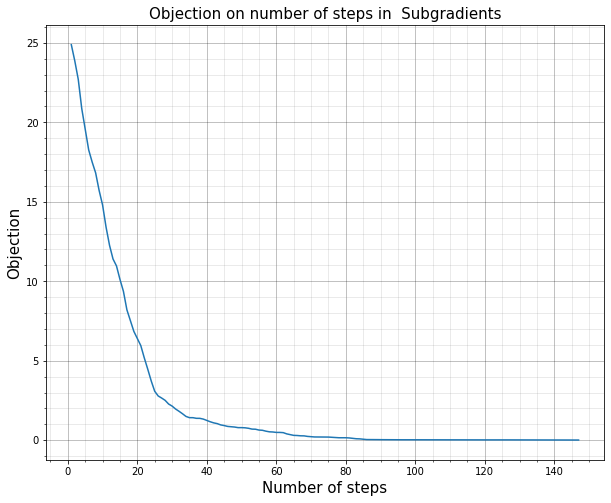

In [2095]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 8])
plt.plot(range(1, len(svm_sb_obj)+1), svm_sb_obj)
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Objection', fontsize=15)
plt.title('Objection on number of steps in  Subgradients', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

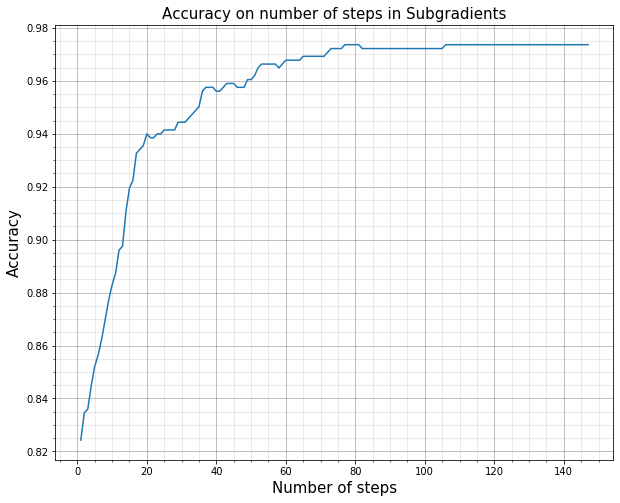

In [2096]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 8])
plt.plot(range(1, len(svm_sb_acc)+1), svm_sb_acc)
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy on number of steps in Subgradients', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

Все результаты(время выполнения, количество итераций, качество) приведены отдельно для каждого метода. Лучший результат показал метод проекции градиента, очень быстрое завершение работы и высокое качество. ADMM показал немного более высокое качество, но большее время. Хуже всего с точки зрения качества отработал Проксимальный метод. Субградиент набрал такое же качество, как и ADMM, но за очень большое время.

# Эффективные алгоритмы для вспомагательных задач бинарной классификации


$$
\min_{w\in R^n} \{ \sum_{i=1}^l \log (1+\exp(-y_i w^Tx_i)) + \lambda \|w\|_1
$$


__Задача.__
$$
\sum_{i=1}^l \log (1+\exp(-y_i w^Tx_i)) + \lambda \|w\|_1 = f(w) + g(w).
$$

In [176]:
from math import *

In [177]:
import numpy as np
y1 = np.zeros((22696,))
data1 = np.zeros((22696, 123))

In [178]:
n = 123 #количество признаков
l = 22696 #размер выборки
lam = 1 #параметр регуляризации
nu = 10 #коэфициент в проксимальном методе

In [179]:
with open('2task.txt') as f: #прочитали данные, в y лежат метки классов, в data -- признаки.
    for idx, line in enumerate(f):
        line = line.split(" ")
        for elem in line:
            if elem == '+1':
                y1[idx] = 1
            elif elem == '-1':
                y1[idx] = -1
            elif elem == '\n':
                continue
            else:
                elem = elem.split(':')
                data1[idx][int(elem[0]) - 1] = float(elem[1])

In [180]:
from sklearn.linear_model import LogisticRegression #обучим модель с таким же штрафом
model = LogisticRegression(penalty = 'l1', C = 1)
model.fit(data1, y1)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [181]:
w_3 = model.coef_[0] #параметры модели

__Реализуем проксимальный метод.__

Шаг метода осуществляется следующим образом:
$$
w^{k+1} = \textbf{Prox}_{\nu g}(w^k - \alpha^k\nabla f).
$$

$$
\textbf{Prox}_{\nu g}(w) = \text{arg}\min_y\{\lambda\|y\|_1 + \dfrac{\nu}{2}\|y - w\|_2^2\}.
$$

Воспользуемся решением этой задачи из первого дз.

$$y_i = \left\{
\begin{aligned}
&-\dfrac{\lambda}{\nu} + w_i, ~-\dfrac{\lambda}{\nu} + w_i > 0
\\
&\dfrac{\lambda}{\nu} + w_i, ~\dfrac{\lambda}{\nu} + w_i < 0
\\
&0, ~ w_i \in \left[-\dfrac{\lambda}{\nu}; -\dfrac{\lambda}{\nu}\right]
\end{aligned}\right.
$$

Далее найдем градиент $f$.

$$
[\nabla f(w)]_j = \sum_{i}^l \dfrac{\text{exp}(-y_iw^Tx_i)}{1 + \text{exp}(-y_iw^Tx_i)}(-y_i)x_i^j
$$


In [182]:
def res(x): #сравнение
    if x > lam/nu:
        return x - lam/nu
    elif x < -lam/nu:
        return x + lam/nu
    else:
        return 0

In [183]:
def Prox_g(w): #проксимальное отображение
    return np.array([x for x in map(res, w)])

In [184]:
def Grad_f(w):
    return np.array([sum([exp(-y[i]*w@data[i])/(1 + exp(-y[i]*w@data[i]))*(-y[i])*data[i, j] for i in range(l)]) for j in range(n)])

In [185]:
import numpy as np

from sklearn.datasets import load_svmlight_file

def get_data():
    data = load_svmlight_file("2task.txt")
    return data

data = get_data()

In [186]:
def gradient_g(w):
    X, y = data[0], data[1]
    return sum(list(map(lambda x,y : -y * x.toarray().squeeze() * (1 - 1 / ( 1 + np.exp(-y*w.T.dot(x.toarray().squeeze())))), X,y)))

In [187]:
def L2(x, y):
    s = 0.0
    for i in range(x.size):
        s+= ((x[i] - y[i])*(x[i] - y[i]))
    return s**0.5

In [199]:
start = time.time()
nu = 1000
lam = 10
w_0 = np.array([1 for _ in range(n)])
w = np.zeros(n)
nev = 10
eps = 0.1
step = 0.0001
k = 1
lg_pr_nev = []
lg_pr_acc = []
while nev > eps:
    w = Prox_g(w_0 - step*gradient_g(w_0))
    nev = L2(w, w_0)
    lg_pr_nev.append(nev)
    acc = accuracy_score(y1, sign(data1@w_0))
    lg_pr_acc.append(acc)
    k += 1
    w_0 = w
end = time.time()

Время выполнения 

In [200]:
end - start

72.55862212181091

Количество итераций

In [201]:
len(lg_pr_acc)

45

Качество

In [202]:
acc

0.8348167077899189

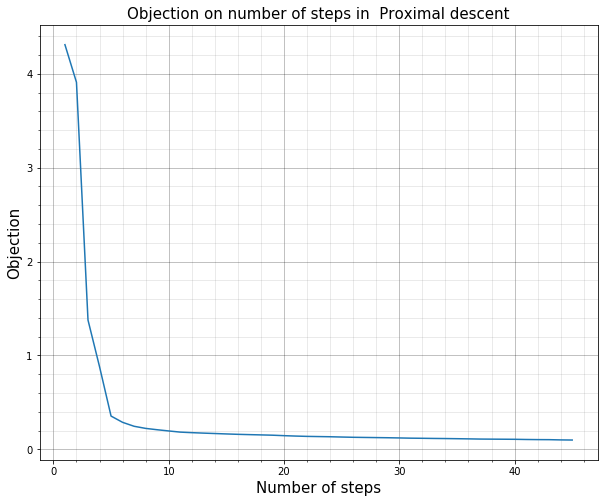

In [203]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, len(lg_pr_nev)+1), lg_pr_nev)
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Objection', fontsize=15)
plt.title('Objection on number of steps in  Proximal descent', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

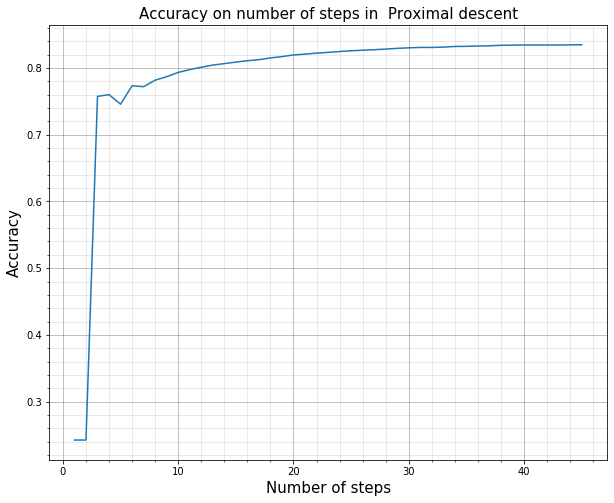

In [204]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, len(lg_pr_acc)+1), lg_pr_acc)
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy on number of steps in  Proximal descent', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

In [205]:
from sklearn.metrics import f1_score #качество модели
accuracy_score(y1, sign(data1@w_3))

0.8468893197039126

In [22]:
def Norm(x):
    s = 0
    for q in x:
        s += q**2
    return s**0.5

__Реализуем быстрый градиентный спуск, используя сглаживание.__

4)Сглаживание

$$f_{\mu} = f(w) + \lambda\|w\|_1 - \frac{\mu}{2}\|u\|_2^2$$. 

Запишем в другом виде

$$f_{\mu} = f(w)+\max\limits_{-1\leq u_i \leq 1}\left[\sum_{i=1}^{n}\lambda u_iw_i - \frac{\mu}{2}u_i^2\right].$$

$$L_i = \frac{\mu}{2}u_i^2 - \lambda u_iw_i + a_i(-1-u_i)+b_i(u_i-1)$$. 

Приравняв градиент нулю, выразим $u_i$:

$$u_i = \frac{a_i-b_i+\lambda w_i}{\mu},$$


Учитывая ограничения, получим

$$
u_i = \left\{\begin{aligned}
&-1,~\lambda w_i \leqslant -\mu
\\
&1,~\lambda w_i  \geqslant \mu
\\
&\dfrac{\lambda w_i}{\mu},~\lambda w_i \in (-\mu, \mu)
\end{aligned}\right.
$$


В силу дифференцируемости можем подставлять $u_{opt}$ в выражение для градиента


$$\nabla f_{\mu}(w) = \nabla f(w) + \lambda u_{opt}.$$

Далее найдем константу Липшица

$d_2(u) \geqslant \frac{\sigma_2}{2}\|u\|_2^2$. $\sigma_2 = 1$, $\|D\|_{1,2} = \max \lambda_{DD^T}\Rightarrow L_{\mu} = \frac{\|D\|_{1,2}}{\mu} \Rightarrow L = L_{\mu} + L(1/2\|y -x\|_2^2) = L_{\mu} + 1$



$f_{\mu}(w_k) = \frac{1}{2}\|y-x_k\|_2^2 + \lambda<u_{opt}, Dx_k> - \frac{\mu\|u_{opt}\|_2^2}{2}, \nabla f_{\mu}(x_k) = x_k - y + \lambda D^Tu_{opt}.$

$$z_k = argmin_{z}\left[\nabla^T f_{\mu}(w_k)(z-w_k)+\frac{L}{2}\|z-w_k\|_2^2\right].$$

Приравняем градиент нулю, найдем $z$:

$$\nabla f(w_k) + L(z-w_k) = 0$$

$$z_k = -\frac{1}{L}\nabla f_{\mu}(w_k) + w_k$$

$$r_k = argmin_r\left[\frac{L}{\sigma_2}d_2(r) +  \sum\limits_{i=0}^k\alpha_i\left(f_{\mu}(w_i) + \nabla^Tf_{\mu}(w_i)(r-w_i)\right)\right].$$


$$r_k = argmin_r \left[\frac{L}{2}\|r\|_2^2 + \sum\limits_{i=0}^k\frac{i+1}{2}(f_{\mu}(w_i) + \nabla^Tf_{\mu}(w_i)(r-w_i))\right].$$

Приравняем градиент нулю, найдем $r$:

$$Lr + \sum\limits_{i=0}^k \frac{i+1}{2}\nabla f(w_i) = 0 \Rightarrow r_k = - \frac{1}{L}\sum\limits_{i=0}^k \frac{i+1}{2}\nabla f_{\mu}(w_i).$$

$$w_{k+1} = \frac{2}{k+3} r_k + \frac{k+1}{k+3}z_k.$$

In [232]:
nev = 10
eps = 0.1
w_1 = np.array([1 for _ in range(n)])
#w_1 = np.random.normal(0, 2, n)
m = 1
lam = 1
L = 100000
z = np.zeros(n)
r = np.zeros(n)

In [233]:
def Smooth_optimal_u(w):
    u = np.zeros(n)
    for i in range(n):
        if w[i] <= -m:
            u[i] = -1
        else:
            if w[i] >= m:
                u[i] = 1
            else:
                u[i] = w[i]/m
    return u

In [234]:
def Smooth_Grad(w, u):
    return gradient_g(w) + lam*u

In [235]:
def Smooth_step_z(w, u, grad):
    return -1/L*grad + w

In [236]:
lg_sm_nev = []
lg_sm_acc = []
start = time.time()
i = 0
while nev > eps:
    u = Smooth_optimal_u(lam*w_1)
    g = Smooth_Grad(w_1, u)
    z = Smooth_step_z(w_1, u, g)
    r = -float((k+1))*g/(2*L) + r  
    w = 2/(i + 3)*r + (i + 1)/(i + 3)*z 
    nev = L2(w, w_1)
    acc = accuracy_score(y1, sign(data1@w_1))
    lg_sm_nev.append(nev)
    lg_sm_acc.append(acc)
    w_1 = w
    i += 1
end = time.time()

Время выполнения

In [237]:
end - start

52.723068714141846

Качество

In [238]:
acc

0.8388702855128657

Количество итераций

In [239]:
i

25

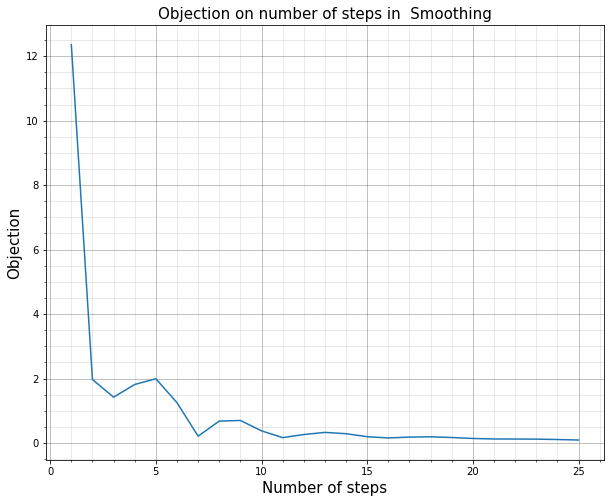

In [240]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, len(lg_sm_nev)+1), lg_sm_nev)
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Objection', fontsize=15)
plt.title('Objection on number of steps in  Smoothing', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

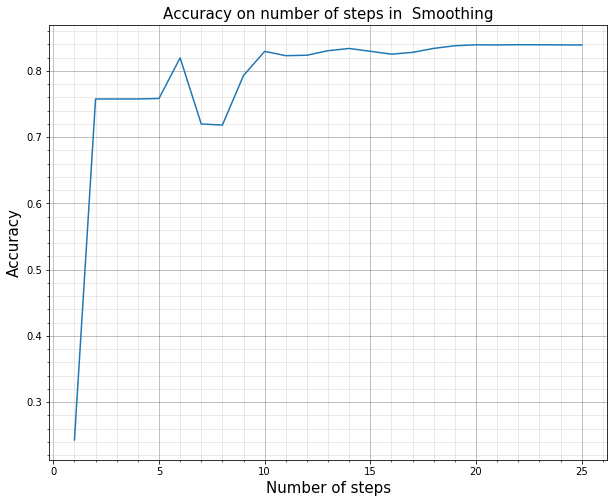

In [241]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, len(lg_sm_acc)+1), lg_sm_acc)
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy on number of steps in  Smoothing', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

__Субградиентный спуск.__

$$
w_{k + 1} = w_{k} - \alpha_k \dfrac{\partial (f(w) + g(w))}{\|\partial(f(w) + g(w))\|_2}
$$

Субградиент суммы равен сумме субградиентов, поэтому $\partial(f(w) + g(w)) = \nabla f(w) + \partial g(w)$

$$
[\partial g(w)]_i = \left\{\begin{aligned}
&\lambda,~w_i > 0,
\\
&-\lambda,~w_i < 0
\\
&[-\lambda; \lambda],~w_i = 0
\end{aligned}\right.
$$

In [244]:
def subgrad_g(w):
    sg = np.zeros(n)
    for i in range(n):
        if w[i] > 0:
            sg[i] = 1
        elif w[i] < 0:
            sg[i] = -1
        else:
            sg[i] = np.random.uniform(-1, 1, 1)[0]
    return sg

In [255]:
nev = 10
eps = 0.01
lam = 100
w_sg = np.array([1 for _ in range(n)])
step = 0.1
norm1 = Norm(gradient_g(w_sg) + lam*subgrad_g(w_sg))
MAX = 45
k = 0

In [256]:
start = time.time()
lg_sg_nev = []
lg_sg_acc = []
while nev > eps and k <= MAX:
    norm = Norm(gradient_g(w_sg) + lam*subgrad_g(w_sg))
    step = 1*norm/norm1
    g = (gradient_g(w_sg) + lam*subgrad_g(w_sg))/norm
    w = w_sg - step*g
    nev = L2(w, w_sg)
    lg_sg_nev.append(nev)
    acc = accuracy_score(y1, sign(data1@w))
    lg_sg_acc.append(acc)
    w_sg = w
    k+=1
end = time.time()

Время выполнения

In [257]:
end - start

183.3811800479889

Качество

In [258]:
acc

0.7992157208318647

Количество итераций

In [259]:
k

46

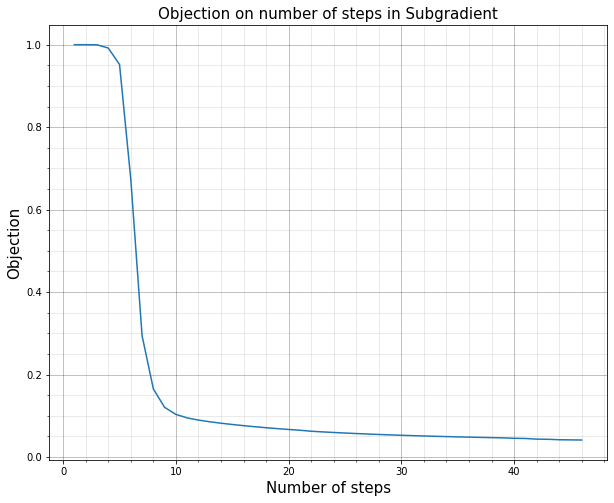

In [262]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, len(lg_sg_nev)+1), lg_sg_nev)
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Objection', fontsize=15)
plt.title('Objection on number of steps in Subgradient', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

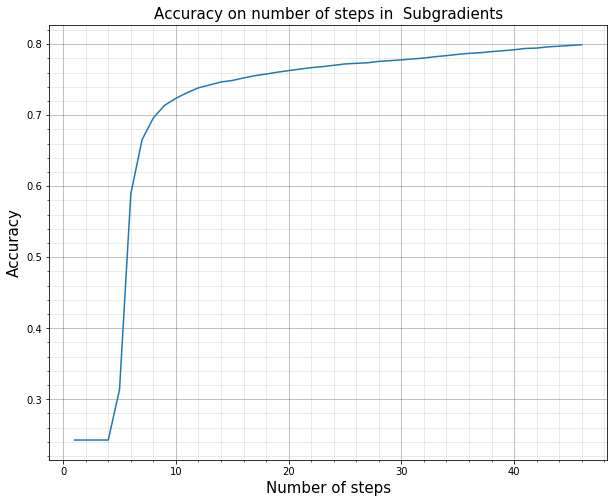

In [261]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, len(lg_sg_acc)+1), lg_sg_acc)
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy on number of steps in  Subgradients', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

__Метод проекции градиента.__

Рассмотрим задачу:

$$
\begin{aligned}
&min_w ~\sum_{i = 1}^l \log(1 + \exp(-y_iw^Tx_i))
\\
&s.t ~\|w\|_{\infty} \leqslant 1
\end{aligned}
$$

Главная задача регуляризатора -- избавиться от мультиколлинераности и упростить параметры модели, сделав их меньше, поэтому задачу можно считать эквилентной. 

Шаг метода будет производиться следующим образом:

$$
w_{k+1} = \Pi_{Q}(w_k - \alpha_k \nabla f(w_k)), ~Q = \{w:~\|w\|_{\infty} \leqslant 1\}
$$

In [266]:
def Proj_grad(w):
    for i in range(n):
        if w[i] > 1:
            w[i] = 1
        elif w[i] < -1:
            w[i] = -1
    return w

In [267]:
nev = 10
eps = 0.1
step = 0.0001
MAX = 30
w_pg = np.array([1 for _ in range(n)])
norm1 = Norm(gradient_g(w_1))

In [268]:
lg_pg_nev = []
lg_pg_acc = []
start = time.time()
k = 0
while nev > eps and k <= MAX:
    g = gradient_g(w_pg)
    w = Proj_grad(w_pg - step*g)
    nev = L2(w, w_pg)
    acc = accuracy_score(y1, sign(data1@w))
    lg_pg_nev.append(nev)
    lg_pg_acc.append(acc)
    w_pg = w
    k+=1
end = time.time()
    

Время выполнения

In [269]:
end - start

28.65678882598877

Качество

In [270]:
acc

0.8051198449065915

Количество итераций

In [272]:
k

16

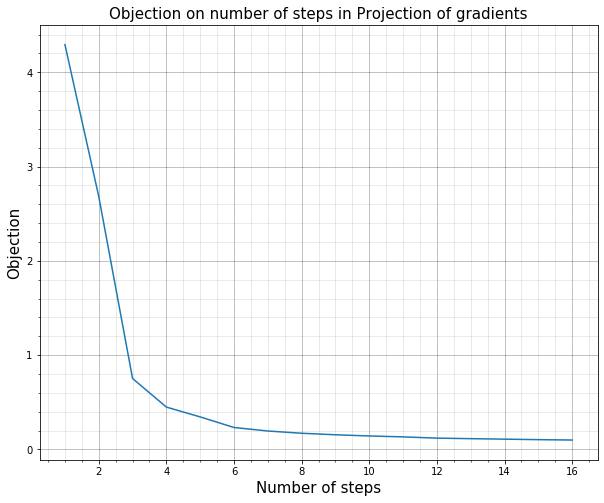

In [273]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, len(lg_pg_nev)+1), lg_pg_nev)
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Objection', fontsize=15)
plt.title('Objection on number of steps in Projection of gradients', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

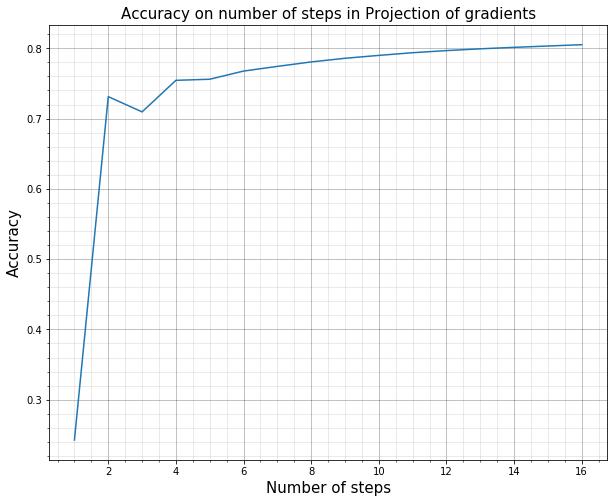

In [274]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, len(lg_pg_acc)+1), lg_pg_acc)
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy on number of steps in Projection of gradients', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

__ADMM.__

Запишем эквивалентную задачу:

$$
\begin{aligned}
&min_{w, z} ~\sum_{i = 1}^l \log(1 + \exp(-y_iw^Tx_i)) + \lambda\|z\|_1
\\
&s.t ~w = z
\end{aligned}
$$

Запишем Лагранжиан:

$$
L_r(w, z, \mu) = f(w) + \lambda\|z\|_1 + \dfrac{1}{2r}\|\mu + r(w - z)\|_2^2 
$$

Тогда получим:

$$
\begin{aligned}
&w_{k+1} = \text{arg}\min_w L_r(w, z_k, \mu_k)
\\
&z_{k+1} = \text{arg}\min_{z} L_r(w_k, z, \mu_k)
\\
&\mu_{k+1} = \mu_k + r(w_{k+1} - z_{k+1})
\end{aligned}
$$

Мы можем решить аналитически вторую и третью задачи, для решения первой на каждой итерации будем использоваться алгоритм BFGS.

Вторая задача: 
$$
z_i = \left\{\begin{aligned}
&\dfrac{w_i - \lambda}{r}, ~w_i > 1
\\
&\dfrac{\sigma(A)_i + 1}{r}, ~\sigma(A)_i < -1
\\
&0, ~\sigma(A)_i \in [-1, 1]
\end{aligned}\right.
$$

$$
z_i = \begin{cases}w_i +\mu_i/r -\lambda/r, \qquad w_i+\mu_i/r  > \lambda/r\\
w_i + \mu_i/r + \lambda/r, \qquad  w_i+\mu_i/r  < -\lambda/r\\
0, ~~~~\qquad\qquad\qquad w_i +\mu_i/r \in [-\lambda/r, \lambda/r]\end{cases}.
$$

In [281]:
def step_ad_z(w, mu):
    z = np.zeros(n)
    for i in range(n):
        if w[i] + mu[i]/r > lam/r:
            z[i] = w[i] + mu[i]/r - lam/r
        elif w[i] + mu[i]/r < -lam/r:
            z[i] = w[i] + mu[i]/r + lam/r
        else:
            z[i] = 0
    return z

In [282]:
def step_ad_mu(mu_ad, w, z):
    return mu_ad + r*(w - z)

In [283]:
def grad_bg(w, m, z, r):
    return gradient_g(w) + m + r*(w - z)

def bfgs(w_k, m, z, n_stop, r, step = 0.00001):
    H_k = np.eye(n)
    g_k = grad_bg(w_k, m, z, r)
    for i in range(n_stop):
        p_k = -H_k.dot(g_k)
        w = w_k + step*p_k
        g = grad_bg(w, m, z, r)
        y_k = g - g_k
        s_k = w - w_k
        y_k = y_k.reshape((n, 1))
        s_k = s_k.reshape((n, 1))
        rho_k = 1/y_k.T.dot(s_k)[0][0]
        I_k = y_k.dot(s_k.T)
        H = (np.eye(n) - rho_k*I_k.T)@H_k@(np.eye(n) - rho_k*I_k) + rho_k*s_k@s_k.T
        w_k = w
    return w_k

In [284]:
nev = 10
eps = 0.1
w_ad = np.array([1 for _ in range(n)])
z_ad = np.array([1 for _ in range(n)])
mu_ad = np.zeros(n)
lam = 100 
r = 1

In [285]:
start = time.time()
met_admm = []
er_admm = []
while nev > eps:
    w = bfgs(w_ad, z_ad, mu_ad, 4, r, step = 0.00001)
    z = step_ad_z(w_ad, mu_ad)
    mu = step_ad_mu(mu_ad, w, z)
    nev = L2(w, w_ad)
    score = accuracy_score(y1, sign(data1@w))
    w_ad = w
    z_ad = z
    mu_ad = mu
    er_admm.append(nev)
    met_admm.append(score)
end = time.time()

Время выполнения

In [286]:
end - start

117.28446626663208

Качество

In [287]:
score

0.7612795206203736

Количество итераций

In [288]:
len(er_admm)

12

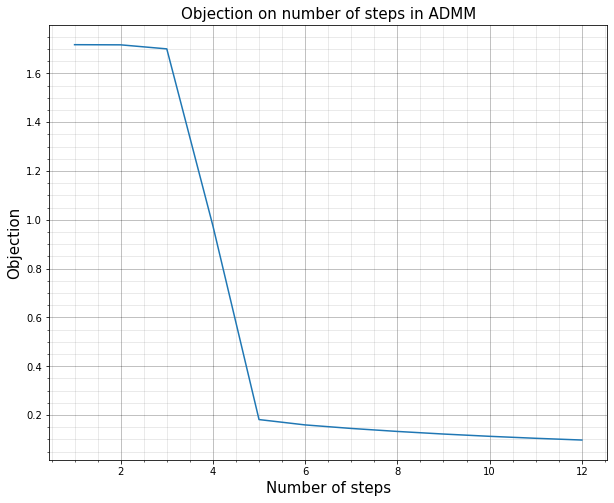

In [289]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, len(er_admm)+1), er_admm)
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Objection', fontsize=15)
plt.title('Objection on number of steps in ADMM', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

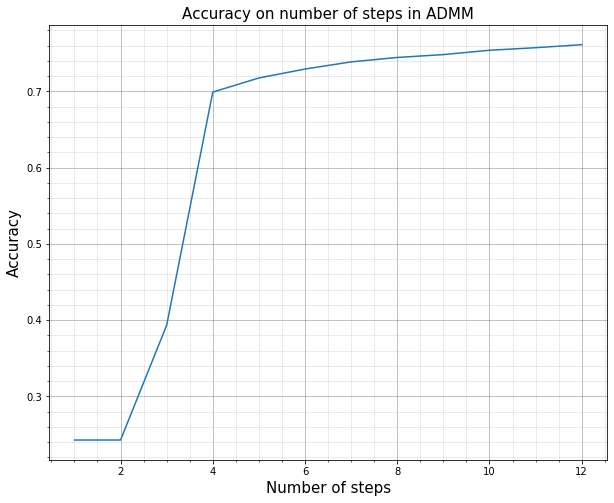

In [290]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, len(met_admm)+1), met_admm)
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy on number of steps in ADMM', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

Все результаты(время выполнения, количество итераций, качество) приведены отдельно для каждого метода. Лучше всего показал себя метод сглаживания с быстрым градиентным спуском. Субградиентный метод, как и ожидалось, работает очень долго. ADMM в принципе плохой метод для этой задачи, так как на каждой итерации приходилось применять другой метод, для сокращения времени алгоритм BFGS делал только 4 итерации на каждом шаге. Также хорошие результаты как по времени, так и по качеству у проксимального градиентного спуска. Самым быстрым методом оказался метод проекции градиента.
